# Quantum Kernel SVM Demo (RBF vs Quantum Kernels)

In this notebook we:

1. Generate a sample dataset.
2. Train a classical SVM with an RBF kernel.
3. Build a quantum feature map (data encoding circuit) and visualize its circuit.
4. Use that feature map to define:
   - A shot-based quantum kernel via AerSimulator (measurement-based).
   - An ideal statevector quantum kernel via Statevector.
5. Train SVMs using the quantum kernel matrices (precomputed kernels).
6. Compare accuracies and decision boundaries:
   - RBF kernel (classical)
   - Quantum kernel (statevector)
   - Quantum kernel (shots, low-resolution grid for speed)

The quantum feature map is implemented in a modular way, so you can easily replace it with your own circuit by editing just one function (or switching a variable).


In [1]:
import numpy as np
from typing import Callable

import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator


## Dataset:

We use `make_moons` to generate a non-linearly separable 2D dataset.

Steps:
1. Generate 80 samples with some noise.
2. Split into train/test sets.
3. Standardize features (zero mean, unit variance) using `StandardScaler`.
   - The quantum kernel will act on the standardized features.
4. Do SVM with a classic rbf kernel


In [8]:
# Generate and split data
X, y = make_moons(n_samples=80, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=0, stratify=y
)

# Standardize (for quantum kernels)
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

X.shape, X_train.shape, X_test.shape
rbf_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", gamma="scale", random_state=0)),
    ]
)

rbf_pipe.fit(X_train, y_train)
y_pred_rbf = rbf_pipe.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)

acc_rbf


0.8571428571428571

## Quantum Feature Map

We define a **feature map** $ \Phi(x) $ that embeds a classical input vector $x$ into a quantum state:

$$
|\Phi(x)\rangle = U_\Phi(x)\,|0\ldots 0\rangle
$$

Current choice:

- One qubit per feature (dimension of `x`).
- For each layer:
  - Apply $ \mathrm{RY}(\pi x_i) $ on qubit *i*.
  - Apply $ \mathrm{RZ}(\pi x_i) $ on qubit *i*.
  - Apply a ring of `CZ` gates to entangle the qubits.

This is easy to change:
- You only need to modify or replace the `feature_map_*` functions.
- All kernel code uses `CURRENT_FEATURE_MAP` so you can swap feature maps in one place.


In [ ]:
def feature_map_ry_rz_entangling(x: np.ndarray, depth: int = 2) -> QuantumCircuit:
    """
    Args:
        x: 1D array of features.
      - 'depth' controls how many such layers are stacked
    """
    x = np.asarray(x).ravel()
    n = len(x)
    qc = QuantumCircuit(n, name="Phi_RY_RZ")

    for _ in range(depth):
        # Local data re-uploading
        for i in range(n):
            qc.ry(np.pi * x[i], i)
        for i in range(n):
            qc.rz(np.pi * x[i], i)
        # Simple entangling ring
        for i in range(n):
            qc.cz(i, (i + 1) % n)

    return qc


def feature_map_ry_only(x: np.ndarray, depth: int = 1) -> QuantumCircuit:
    """
    Simpler baseline feature map: only RY rotations, no entanglement.
    Args:
        x: 1D array of features.
      - 'depth' controls how many such layers are stacked
    """
    x = np.asarray(x).ravel()
    n = len(x)
    qc = QuantumCircuit(n, name="Phi_RY_only")

    for _ in range(depth):
        for i in range(n):
            qc.ry(np.pi * x[i], i)

    return qc


def feature_map_zz_kernel(
    x: np.ndarray,
    reps: int = 2,
    scale_single: float = np.pi / 2,
    scale_pair: float = np.pi / 2,
) -> QuantumCircuit:
    """
    Args:
        x: 1D array of features.
        reps: number of data-encoding layers.
        scale_single: scaling factor for single-qubit Z terms.
        scale_pair: scaling factor for ZZ pairwise terms.

    """
    x = np.asarray(x).ravel()
    n = len(x)
    qc = QuantumCircuit(n, name="Phi_ZZ")

    # equal superposition
    qc.h(range(n))

    for _ in range(reps):
        # Single-qubit Z encodings
        for i in range(n):
            qc.rz(scale_single * x[i], i)

        # Two-qubit ZZ encodings (pairwise products x_i x_j)
        for i in range(n):
            for j in range(i + 1, n):
                qc.rzz(scale_pair * x[i] * x[j], i, j)

    return qc




CURRENT_FEATURE_MAP: Callable[[np.ndarray], QuantumCircuit] = feature_map_zz_kernel

x_sample = np.array([0.3, -0.7])

qc_sample = CURRENT_FEATURE_MAP(x_sample)
print(qc_sample.draw())  # Text-based diagram in the notebook output

# For a graphical diagram
try:
    qc_sample.draw("mpl")
    plt.show()
except Exception as e:
    print("Graphical drawing failed (you may not have the mpl drawer installed):", e)



     ┌───┐┌─────────────┐               ┌─────────────┐               
q_0: ┤ H ├┤ Rz(0.47124) ├─■─────────────┤ Rz(0.47124) ├─■─────────────
     ├───┤├─────────────┤ │ZZ(-0.32987) ├─────────────┤ │ZZ(-0.32987) 
q_1: ┤ H ├┤ Rz(-1.0996) ├─■─────────────┤ Rz(-1.0996) ├─■─────────────
     └───┘└─────────────┘               └─────────────┘               


## From Feature Map to Kernel Matrix

The quantum kernel is defined as:

$$
K(x, z) = \bigl|\langle \Phi(x) \mid \Phi(z) \rangle\bigr|^2
$$

We implement this in two ways:

1. Statevector kernel (ideal, noiseless):
   - Simulate the state $|\Phi(x)\rangle$ and $|\Phi(z)\rangle$.
   - Compute the squared magnitude of their inner product.

2. Shot-based kernel (measurement-based, hardware-like):
   - Build a circuit $ \Phi(x)\,\Phi(z)^\dagger $ applied to $|0\ldots 0\rangle$.
   - Measure all qubits.
   - The probability of measuring all zeros equals the kernel value:

$$
K(x,z)
= \bigl|\langle 0\ldots 0\mid \Phi(z)^\dagger \Phi(x) \mid 0\ldots 0\rangle\bigr|^2.
$$

We’ll create helper functions:

- `_pair_overlap_circuit(x, z, fmap)`: builds the overlap circuit with measurement.
- `kernel_matrix_shots(XA, XB, fmap, ...)`
- `kernel_matrix_statevector(XA, XB, fmap)`

Then, we will train the SVM with quantum kernel

In [20]:
def _pair_overlap_circuit(
    x: np.ndarray,
    z: np.ndarray,
    fmap: Callable[[np.ndarray], QuantumCircuit]
) -> QuantumCircuit:

    x = np.asarray(x)
    z = np.asarray(z)
    n = len(x)

    qc_x = fmap(x)
    qc_z = fmap(z)

    qc = QuantumCircuit(n)
    qc.compose(qc_x, inplace=True)
    qc.compose(qc_z.inverse(), inplace=True)
    qc.measure_all()

    return qc




def kernel_matrix_shots(
    XA: np.ndarray,
    XB: np.ndarray,
    fmap: Callable[[np.ndarray], QuantumCircuit],
    shots: int = 1024,
    seed: int = 1234,
) -> np.ndarray:
    """
    Compute the quantum kernel matrix using shots from AerSimulator.
    K[i,j] = prob(all-zero outcome) for pair (XA[i], XB[j]).
    """
    XA = np.asarray(XA)
    XB = np.asarray(XB)
    nA, nB = len(XA), len(XB)
    n = XA.shape[1]

    sim = AerSimulator()
    K = np.zeros((nA, nB), dtype=float)
    allzero = "0" * n

    # Use symmetry if matrices match exactly (saves half the work).
    symmetric = (XA is XB) or (XA.shape == XB.shape and np.allclose(XA, XB))

    if symmetric:
        circuits, pairs = [], []
        for i in range(nA):
            for j in range(i, nB):
                circuits.append(_pair_overlap_circuit(XA[i], XB[j], fmap))
                pairs.append((i, j))
        tcircs = transpile(circuits, sim)
        result = sim.run(tcircs, shots=shots, seed_simulator=seed).result()

        for idx, (i, j) in enumerate(pairs):
            counts = result.get_counts(idx)
            prob_zeros = counts.get(allzero, 0) / shots
            K[i, j] = K[j, i] = prob_zeros
    else:
        circuits, pairs = [], []
        for i in range(nA):
            for j in range(nB):
                circuits.append(_pair_overlap_circuit(XA[i], XB[j], fmap))
                pairs.append((i, j))
        tcircs = transpile(circuits, sim)
        result = sim.run(tcircs, shots=shots, seed_simulator=seed).result()
        for idx, (i, j) in enumerate(pairs):
            counts = result.get_counts(idx)
            K[i, j] = counts.get(allzero, 0) / shots

    return K


def kernel_matrix_statevector(
    XA: np.ndarray,
    XB: np.ndarray,
    fmap: Callable[[np.ndarray], QuantumCircuit],
) -> np.ndarray:
    """
    Compute the ideal statevector quantum kernel matrix:
      K[i,j] = |<Phi(XA[i]) | Phi(XB[j])>|^2
    """
    XA = np.asarray(XA)
    XB = np.asarray(XB)
    nA, nB = len(XA), len(XB)

    svA, svB = [], []

    # Precompute statevectors for XA
    for i in range(nA):
        qc = fmap(XA[i])
        psi = Statevector.from_label("0" * qc.num_qubits).evolve(qc)
        svA.append(psi)

    # Precompute statevectors for XB
    for j in range(nB):
        qc = fmap(XB[j])
        psi = Statevector.from_label("0" * qc.num_qubits).evolve(qc)
        svB.append(psi)

    # Fill kernel matrix
    K = np.zeros((nA, nB), dtype=float)
    for i in range(nA):
        for j in range(nB):
            overlap = svA[i].data.conj().dot(svB[j].data)
            K[i, j] = np.abs(overlap) ** 2

    return K

# Quantum kernel (shots)
K_train_shots = kernel_matrix_shots(X_train_std, X_train_std, CURRENT_FEATURE_MAP, shots=1024)
K_test_shots = kernel_matrix_shots(X_test_std, X_train_std, CURRENT_FEATURE_MAP, shots=1024)

qsvc_shots = SVC(kernel="precomputed", C=1.0, random_state=0)
qsvc_shots.fit(K_train_shots, y_train)
y_pred_qshots = qsvc_shots.predict(K_test_shots)
acc_qshots = accuracy_score(y_test, y_pred_qshots)

# Quantum kernel (statevector)
K_train_sv = kernel_matrix_statevector(X_train_std, X_train_std, CURRENT_FEATURE_MAP)
K_test_sv = kernel_matrix_statevector(X_test_std, X_train_std, CURRENT_FEATURE_MAP)

qsvc_sv = SVC(kernel="precomputed", C=1.0, random_state=0)
qsvc_sv.fit(K_train_sv, y_train)
y_pred_qsv = qsvc_sv.predict(K_test_sv)
acc_qsv = accuracy_score(y_test, y_pred_qsv)

acc_rbf, acc_qshots, acc_qsv


(0.8571428571428571, 0.7857142857142857, 0.7857142857142857)

## Decision Boundary Drawing

Next, we'll try to write down the function for the decision boundary and draw the boundary along with the data points.

RBF acc     = 0.857
Q kernel shots acc     = 0.786
Q kernel statevector acc = 0.786

RBF SVM decision function:
  f(x) = Σ λ_i exp(-γ||x-s_i||²) + b
  γ=0.5000, b=0.1389
  λ[0]=-1.0000, s[0]=[ 0.093 -0.14 ]
  λ[1]=-1.0000, s[1]=[-0.605  0.399]
  λ[2]=-0.1934, s[2]=[-1.364  1.266]
  λ[3]=-1.0000, s[3]=[0.693 0.586]
  λ[4]=-0.6747, s[4]=[0.128 0.832]
  λ[5]=-1.0000, s[5]=[ 0.654 -0.493]
  λ[6]=-0.7809, s[6]=[-1.971 -0.087]
  λ[7]=-1.0000, s[7]=[ 0.576 -0.88 ]
  λ[8]=-0.7184, s[8]=[0.385 1.484]
  λ[9]=-1.0000, s[9]=[-1.08  -0.527]
  λ[10]=-0.5509, s[10]=[-1.415  0.225]
  λ[11]=-1.0000, s[11]=[-0.09   0.431]
  λ[12]=-0.4653, s[12]=[-0.433  0.61 ]
  λ[13]=+1.0000, s[13]=[ 0.757 -0.207]
  λ[14]=+1.0000, s[14]=[-0.027  0.372]
  λ[15]=+0.0862, s[15]=[ 0.257 -1.82 ]
  λ[16]=+1.0000, s[16]=[-0.264 -0.407]
  λ[17]=+0.9078, s[17]=[-0.249 -0.871]
  λ[18]=+1.0000, s[18]=[-0.882 -0.18 ]
  λ[19]=+1.0000, s[19]=[-0.568 -0.431]
  λ[20]=+1.0000, s[20]=[1.082 0.291]
  λ[21]=+0.1276, s[21]=[-0.004 -1.802]


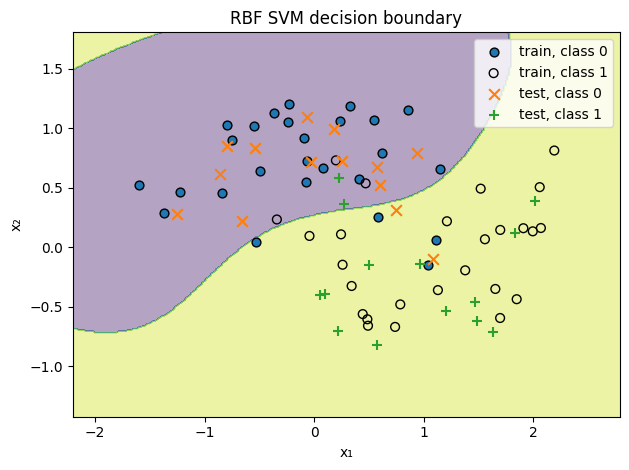

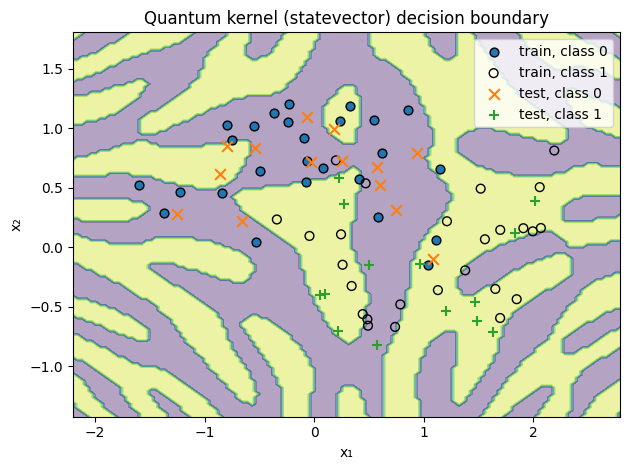

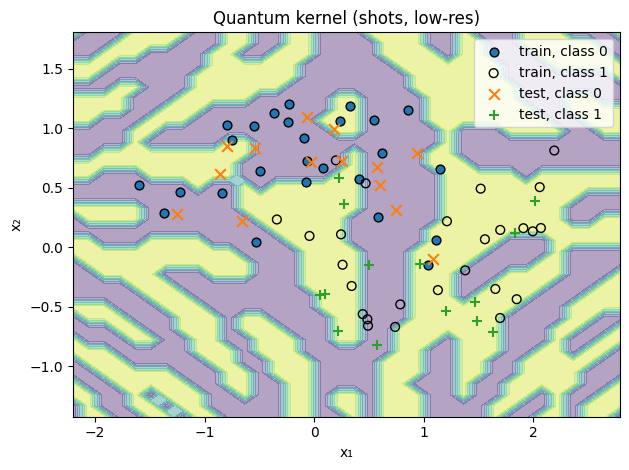

In [21]:
def format_decision_function_rbf(svc: SVC, scaler: StandardScaler, name: str = "RBF SVM") -> str:
    gamma_param = svc.get_params()["gamma"]
    gamma_ = svc._gamma if gamma_param == "scale" else float(gamma_param)
    lambdas = svc.dual_coef_[0]
    SV = svc.support_vectors_
    b = float(svc.intercept_[0])

    lines = [
        f"{name} decision function:",
        "  f(x) = Σ λ_i exp(-γ||x-s_i||²) + b",
        f"  γ={gamma_:.4f}, b={b:.4f}",
    ]
    for i, (lam, s) in enumerate(zip(lambdas, SV)):
        lines.append(f"  λ[{i}]={lam:+.4f}, s[{i}]={np.array2string(s, precision=3)}")
    return "\n".join(lines)


def format_decision_function_quantum(svc: SVC, X_train_std: np.ndarray, kernel_label: str) -> str:
    lambdas = svc.dual_coef_[0]
    sv_idx = svc.support_
    b = float(svc.intercept_[0])

    lines = [
        f"{kernel_label} decision function:",
        "  f(x)=Σ λ_i K_Q(s_i,x)+b",
        f"  b={b:.4f}",
    ]
    for i, lam in enumerate(lambdas):
        s = X_train_std[sv_idx[i]]
        lines.append(f"  λ[{i}]={lam:+.4f}, s[{i}]={np.array2string(s, precision=3)}")
    return "\n".join(lines)
print(f"RBF acc     = {acc_rbf:.3f}")
print(f"Q kernel shots acc     = {acc_qshots:.3f}")
print(f"Q kernel statevector acc = {acc_qsv:.3f}\n")

print(format_decision_function_rbf(
    rbf_pipe.named_steps["svc"],
    rbf_pipe.named_steps["scaler"]
))
print()
print(format_decision_function_quantum(qsvc_shots, X_train_std, "Quantum (shots)"))
print()
print(format_decision_function_quantum(qsvc_sv, X_train_std, "Quantum (statevector)"))

def _make_mesh(X_all: np.ndarray, nx: int, ny: int, padding: float = 0.6):
    x_min, x_max = X_all[:, 0].min() - padding, X_all[:, 0].max() + padding
    y_min, y_max = X_all[:, 1].min() - padding, X_all[:, 1].max() + padding
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, nx),
        np.linspace(y_min, y_max, ny),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, grid


def _plot_decision_boundary(title: str, xx, yy, Z,
                            X_train, y_train,
                            X_test, y_test):
    """
    Plot decision regions and four categories of points:
      - Train, class 0
      - Train, class 1
      - Test,  class 0
      - Test,  class 1
    """
    Z = Z.reshape(xx.shape)
    plt.figure()
    # Decision regions
    plt.contourf(xx, yy, Z, alpha=0.4)

    # Masks for categories
    train_0 = (y_train == 0)
    train_1 = (y_train == 1)
    test_0  = (y_test == 0)
    test_1  = (y_test == 1)

    # Train points
    plt.scatter(
        X_train[train_0, 0], X_train[train_0, 1],
        s=40, marker="o", edgecolors="k", label="train, class 0"
    )
    plt.scatter(
        X_train[train_1, 0], X_train[train_1, 1],
        s=40, marker="o", edgecolors="k", facecolors="none",
        label="train, class 1"
    )

    # Test points
    plt.scatter(
        X_test[test_0, 0], X_test[test_0, 1],
        s=60, marker="x", label="test, class 0"
    )
    plt.scatter(
        X_test[test_1, 0], X_test[test_1, 1],
        s=60, marker="+", label="test, class 1"
    )

    plt.title(title)
    plt.legend(loc="best")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.tight_layout()
    plt.show()


def _grid_predict_statevector(
    svc: SVC,
    grid_std: np.ndarray,
    X_train_std: np.ndarray,
) -> np.ndarray:
    K_grid = kernel_matrix_statevector(grid_std, X_train_std, CURRENT_FEATURE_MAP)
    return svc.predict(K_grid)


def _grid_predict_shots(
    svc: SVC,
    grid_std: np.ndarray,
    X_train_std: np.ndarray,
    shots: int = 256,
    batch: int = 60,
) -> np.ndarray:
    preds = []
    for start in range(0, len(grid_std), batch):
        end = min(len(grid_std), start + batch)
        K_batch = kernel_matrix_shots(
            grid_std[start:end], X_train_std, CURRENT_FEATURE_MAP, shots=shots
        )
        preds.append(svc.predict(K_batch))
    return np.concatenate(preds, axis=0)

# High-resolution grid for RBF
xx_rbf, yy_rbf, grid_rbf = _make_mesh(
    np.vstack([X_train, X_test]),
    nx=300,
    ny=300,
)

Z_rbf = rbf_pipe.predict(grid_rbf)
_plot_decision_boundary(
    "RBF SVM decision boundary",
    xx_rbf,
    yy_rbf,
    Z_rbf,
    X_train,
    y_train,
    X_test,
    y_test,
)
# Medium-resolution grid for statevector quantum kernel
xx_sv_plot, yy_sv_plot, grid_sv = _make_mesh(
    np.vstack([X_train, X_test]),
    nx=120,
    ny=120,
)

grid_sv_std = scaler.transform(grid_sv)
Z_sv = _grid_predict_statevector(qsvc_sv, grid_sv_std, X_train_std)

_plot_decision_boundary(
    "Quantum kernel (statevector) decision boundary",
    xx_sv_plot,
    yy_sv_plot,
    Z_sv,
    X_train,
    y_train,
    X_test,
    y_test,
)
# Low-resolution grid for shot-based quantum kernel (faster)
xx_q, yy_q, grid_q = _make_mesh(
    np.vstack([X_train, X_test]),
    nx=36,
    ny=36,
)

grid_q_std = scaler.transform(grid_q)
Z_q = _grid_predict_shots(
    qsvc_shots,
    grid_q_std,
    X_train_std,
    shots=512,  
    batch=60,
)

_plot_decision_boundary(
    "Quantum kernel (shots, low-res)",
    xx_q,
    yy_q,
    Z_q,
    X_train,
    y_train,
    X_test,
    y_test,
)



## Hyperparameter Tuning

Now that we have classical and quantum kernel SVMs working, the next step is adjust quantum circuit for performance and generalization. I included 3 different quantum kernels to try and parameters to tune. See comments in Quantum Feature Map section for detail.
